In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import Row, Column
from pyspark.sql.functions import col, lag, percent_rank, monotonically_increasing_id, to_date, date_trunc, year, when, quarter, pandas_udf, PandasUDFType
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType
from datetime import datetime
from matplotlib.dates import date2num, DateFormatter
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression



# Create a Spark session
spark = SparkSession.builder.appName("CurrencyAnalysis").getOrCreate()


In [0]:

file_path = "dbfs:/FileStore/tables/currency_data-2.csv"  
schema_def = StructType([StructField('Date', DateType(), True),
                         StructField('Name', StringType(), True),
                         StructField('Open', DoubleType(), True),
                         StructField('High', DoubleType(), True),
                         StructField('Low', DoubleType(), True),
                         StructField('Close', DoubleType(), True)
])

df = spark.read.csv(file_path, encoding="UTF-8", schema=schema_def)
df.cache()
df.show()

+----------+----------+------+-------+-------+-------+
|      Date|      Name|  Open|   High|    Low|  Close|
+----------+----------+------+-------+-------+-------+
|      null|      Name|  null|   null|   null|   null|
|2024-01-19|EUR to HUF|378.85|383.494| 378.17| 381.46|
|2024-01-12|EUR to HUF|377.69|380.342|376.916|  378.9|
|2024-01-05|EUR to HUF|383.11| 383.29|  377.1| 377.49|
|2023-12-29|EUR to HUF|380.92| 383.45| 380.31| 382.54|
|2023-12-22|EUR to HUF| 382.3|385.647| 380.27|380.631|
|2023-12-15|EUR to HUF|380.77|383.629| 377.82|  382.5|
|2023-12-08|EUR to HUF|378.57|382.696|377.945| 380.86|
|2023-12-01|EUR to HUF|379.99|381.452|376.469| 377.94|
|2023-11-24|EUR to HUF| 377.8| 381.94| 377.49| 380.09|
|2023-11-17|EUR to HUF|376.77|379.094| 375.13| 378.59|
|2023-11-10|EUR to HUF|378.86| 380.46|  376.3| 376.83|
|2023-11-03|EUR to HUF|383.26|384.028| 378.09| 379.41|
|2023-10-27|EUR to HUF| 381.7|  386.1| 380.46| 383.06|
|2023-10-20|EUR to HUF|387.45| 388.35| 381.36| 381.57|
|2023-10-1

In [0]:
df = df.withColumn("row_id", monotonically_increasing_id())
df = df.filter(df.row_id != 0)
df = df.fillna(-1, 'Open')
df = df.fillna(-1, 'High')
df = df.fillna(-1, 'Low')
df = df.fillna(-1, 'Close')

df.show()

+----------+----------+------+-------+-------+-------+------+
|      Date|      Name|  Open|   High|    Low|  Close|row_id|
+----------+----------+------+-------+-------+-------+------+
|2024-01-19|EUR to HUF|378.85|383.494| 378.17| 381.46|     1|
|2024-01-12|EUR to HUF|377.69|380.342|376.916|  378.9|     2|
|2024-01-05|EUR to HUF|383.11| 383.29|  377.1| 377.49|     3|
|2023-12-29|EUR to HUF|380.92| 383.45| 380.31| 382.54|     4|
|2023-12-22|EUR to HUF| 382.3|385.647| 380.27|380.631|     5|
|2023-12-15|EUR to HUF|380.77|383.629| 377.82|  382.5|     6|
|2023-12-08|EUR to HUF|378.57|382.696|377.945| 380.86|     7|
|2023-12-01|EUR to HUF|379.99|381.452|376.469| 377.94|     8|
|2023-11-24|EUR to HUF| 377.8| 381.94| 377.49| 380.09|     9|
|2023-11-17|EUR to HUF|376.77|379.094| 375.13| 378.59|    10|
|2023-11-10|EUR to HUF|378.86| 380.46|  376.3| 376.83|    11|
|2023-11-03|EUR to HUF|383.26|384.028| 378.09| 379.41|    12|
|2023-10-27|EUR to HUF| 381.7|  386.1| 380.46| 383.06|    13|
|2023-10

In [0]:
# Analiza cene evra u dinarima kroz vreme

#Na grafikonu ispod mozemo videti promenu cene evra u dinarskoj protivvrenosti u proteklih 10-ak godina. Prvo cemo iz skupa podataka isfiltrirati one redove koji prikazuju dinarsku protivrednost evrima. Posto je skup podataka #previse opsiran da bi citanje grafa bilo moguce odradili smo agregaciju odnosno uzeli smo prosek podataka u odredjenom vremenskom periodu i dobili proredjeni grafik. 
#Kako je praksa u svetu finansija da se pri analizama uzima Close vrednost ta metoda je primenjena i u ovoj analizi. Close vrednost je ona koja je bila vazeca na samom kraju posmatranog perioda - u ovom slucaju nedelje. 


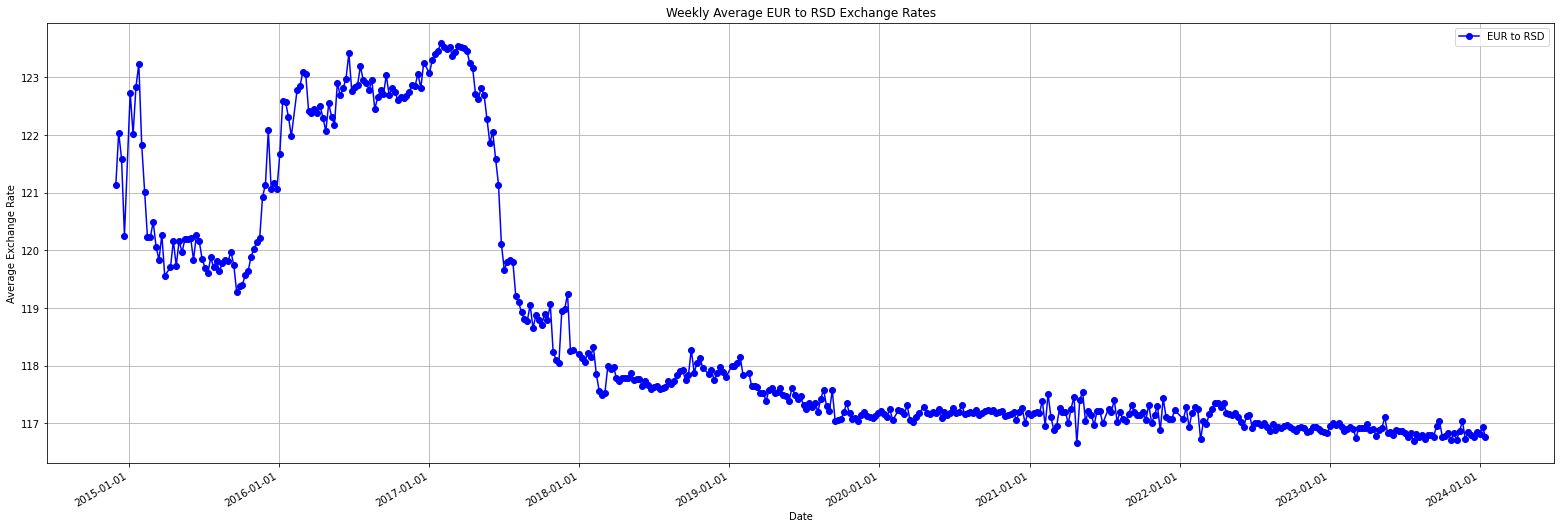

In [0]:
df_eur_to_rsd = df.filter(col('Name') == "EUR to RSD")
# Agregacija
df_aggregated = df_eur_to_rsd.groupBy(date_trunc("week", "Date").alias("WeekEnd")) \
                 .agg({"Close": "avg"}) \
                 .orderBy("WeekEnd")

# Velicina grafika
plt.figure(figsize=(27, 9))

# Ekstrakovanje podataka
eur_to_rsd_data = df_aggregated.collect()
dates_eur_to_rsd = [date2num(row["WeekEnd"]) for row in eur_to_rsd_data]
exchange_rates_eur_to_rsd = [row["avg(Close)"] for row in eur_to_rsd_data]

# Iscrtavanje grafika
plt.plot_date(dates_eur_to_rsd, exchange_rates_eur_to_rsd, '-o', label='EUR to RSD', color='blue')

# Dodavanje label-a
plt.xlabel('Date')
plt.ylabel('Average Exchange Rate')
plt.title('Weekly Average EUR to RSD Exchange Rates')

# Formatiranje
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Prikaz
plt.grid(True)
plt.legend()
plt.show()

In [0]:
#Iz prikazanog grafika mozemo primetiti da nakon nestabilnosti dinara u periodu od kraja 2014. godine do sredine 2017. godine sledi najpre nagli a zatim dosta blazi ali stabilan pad dinara koji trenutno u 2024. godini dostize skoro i najnizu vrednost u poslednjih 10 godina - jedino je niza vrenodst bila sredinom 2021. godine pri tadasnjim oscilacijama.

In [0]:
#Linearna regresija

#Primenom linearne regresije na dati skup podataka, na osnovu postojecih 'trendova' tj na osnovu toga kako se dinarska protivvrednost menjala kroz nedelje, mesece i godine, mozemo pretpostaviti kako ce se ona menjati u buducnosti. Naravno linearna regresija u ovom slucaju nije primenjiva u stvarnom zivotu kako prethodnjo stanje dinarske protivvrednosti ne utice na njegovo buduce stanje ali radi demonstracije ona je upotrebljena na ovaj skup podataka.

/databricks/spark/python/pyspark/sql/pandas/functions.py:396: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


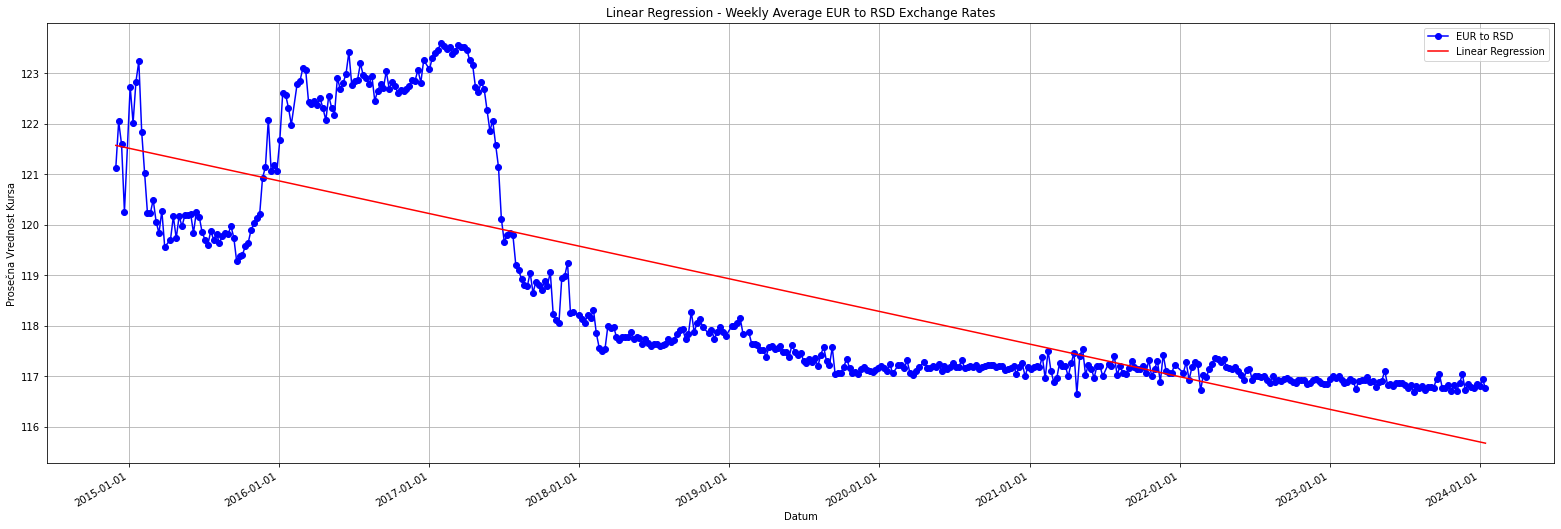

In [0]:

# Filtriranje podataka za evro u RSD
df_eur_to_rsd = df.filter(col('Name') == "EUR to RSD")

# Agregacija podataka po nedeljama
df_aggregated = df_eur_to_rsd.groupBy(date_trunc("week", "Date").alias("WeekEnd")) \
                             .agg({"Close": "avg"}) \
                             .orderBy("WeekEnd")

# Pretvaranje tipa podataka
df_aggregated = df_aggregated.withColumn("avg(Close)", col("avg(Close)").cast(DoubleType()))

# Dodavanje nove kolone za numerički prikaz datuma
@pandas_udf(DoubleType(), PandasUDFType.SCALAR)
def date_to_numeric_udf(pd_series):
    return pd.Series(date2num(pd.to_datetime(pd_series)))

df_aggregated = df_aggregated.withColumn("NumericDate", date_to_numeric_udf(df_aggregated["WeekEnd"]))

# Ekstrakcija podataka
eur_to_rsd_data = df_aggregated.collect()
dates_eur_to_rsd = [row["NumericDate"] for row in eur_to_rsd_data]
exchange_rates_eur_to_rsd = [row["avg(Close)"] for row in eur_to_rsd_data]

# Priprema podataka za linearnu regresiju
vector_assembler = VectorAssembler(inputCols=["NumericDate"], outputCol="features")
df_features = vector_assembler.transform(df_aggregated).select("features", "avg(Close)").withColumnRenamed("avg(Close)", "label")

# Inicijalizacija i treniranje modela linearne regresije
lr = LinearRegression(featuresCol="features", labelCol="label")
model = lr.fit(df_features)

# Predviđanje vrednosti
df_predictions = model.transform(df_features)

# Iscrtavanje grafika
plt.figure(figsize=(27, 9))
plt.plot_date(dates_eur_to_rsd, exchange_rates_eur_to_rsd, '-o', label='EUR to RSD', color='blue')

# Dodavanje regresione linije
plt.plot_date(dates_eur_to_rsd, df_predictions.select("prediction").toPandas()["prediction"], '-r', label='Linear Regression')

# Dodavanje label-a
plt.xlabel('Datum')
plt.ylabel('Prosečna Vrednost Kursa')
plt.title('Linear Regression - Weekly Average EUR to RSD Exchange Rates')

# Formatiranje
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Prikaz
plt.grid(True)
plt.legend()
plt.show()

In [0]:
# Analiza vrednosti dinara u evrima 

#Slicnom metodologijom kao i na prethodnom grafiku mozemo odrediti grafik i za vrednost dinara u evrima. Ocekujemo da ce ova dva grafika biti osno simetricna.

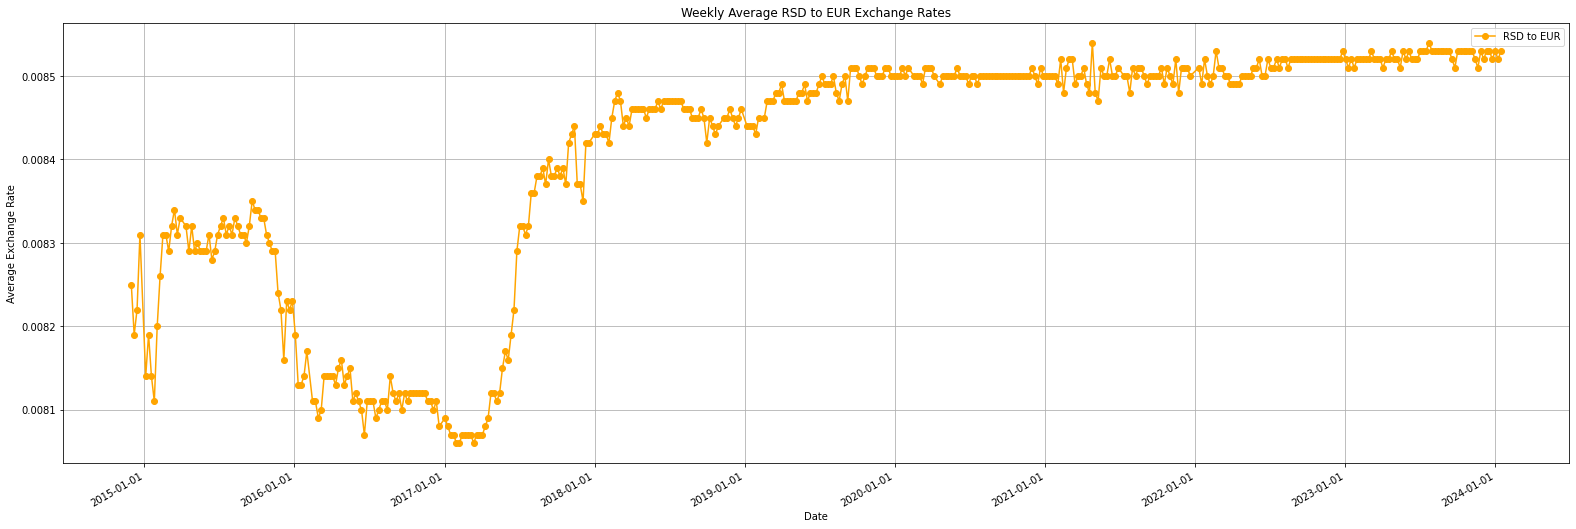

In [0]:
df_rsd_to_eur = df.filter(col('Name') == "RSD to EUR")
# Agregacija
df_aggregated = df_rsd_to_eur.groupBy(date_trunc("week", "Date").alias("WeekEnd")) \
                 .agg({"Close": "avg"}) \
                 .orderBy("WeekEnd")

# Velicina grafika
plt.figure(figsize=(27, 9))

# Ekstrakovanje podataka
rsd_to_eur_data = df_aggregated.collect()
dates_rsd_to_eur = [date2num(row["WeekEnd"]) for row in rsd_to_eur_data]
exchange_rates_rsd_to_eur = [row["avg(Close)"] for row in rsd_to_eur_data]

# Iscrtavanje grafika
plt.plot_date(dates_rsd_to_eur, exchange_rates_rsd_to_eur, '-o', label='RSD to EUR', color='orange')

# Dodavanje label-a
plt.xlabel('Date')
plt.ylabel('Average Exchange Rate')
plt.title('Weekly Average RSD to EUR Exchange Rates')

# Formatiranje
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Prikaz
plt.grid(True)
plt.legend()
plt.show()

In [0]:
#Kako smo na osnovu prethodnog grafika mogli da zakljucimo da dinar slabi u odnosu na evro tako mozemo zakluciti iz ovog da evro jaca u odnosu na dinar. Ocekivana sto se tice simetrije su dostignuta.

In [0]:
# Analiza promene kursa u odnosu na prethodnu godinu

#Kada gledamo promenu dinarske protivvrednosti za svaku godinu (ponovo uzimamo vrednost Close za svaku nedelju jer je to najlogicnija vrednost od ponudjene 4) mozemo videti ekonomski napredak za svaku godinu pojedinacno, naravno u odnosu na drzave koje koriste evro kao valutu, iz dobijenog grafika mozemo videti variranje od -1.5 do 2.5 dinara po godini pa mozemo zakluciti da u prethodnih 10 godina nije doslo do rapidnog i kratkorocnog nazadovanja ali ni napretka kada je jacina valute u pitanju.

+----------+--------+--------------+--------------------+
|      Date|   Close|Previous_Close|       Yearly_Change|
+----------+--------+--------------+--------------------+
|2014-12-05|121.1247|          null|                null|
|2014-12-12|122.0411|      121.1247|  0.9163999999999959|
|2014-12-19|121.5883|      122.0411| -0.4527999999999963|
|2014-12-26|120.2533|      121.5883|  -1.335000000000008|
|2015-01-09|122.7327|      120.2533|  2.4793999999999983|
|2015-01-16|122.0089|      122.7327| -0.7237999999999971|
|2015-01-23|122.8303|      122.0089|   0.821399999999997|
|2015-01-30|123.2322|      122.8303|  0.4019000000000119|
|2015-02-06|121.8324|      123.2322|  -1.399799999999999|
|2015-02-13|121.0153|      121.8324| -0.8171000000000106|
|2015-02-20|120.2295|      121.0153| -0.7857999999999947|
|2015-02-27|120.2273|      120.2295|-0.00220000000000...|
|2015-03-06|120.4925|      120.2273|  0.2652000000000072|
|2015-03-13|120.0617|      120.4925|-0.43080000000000496|
|2015-03-20| 1

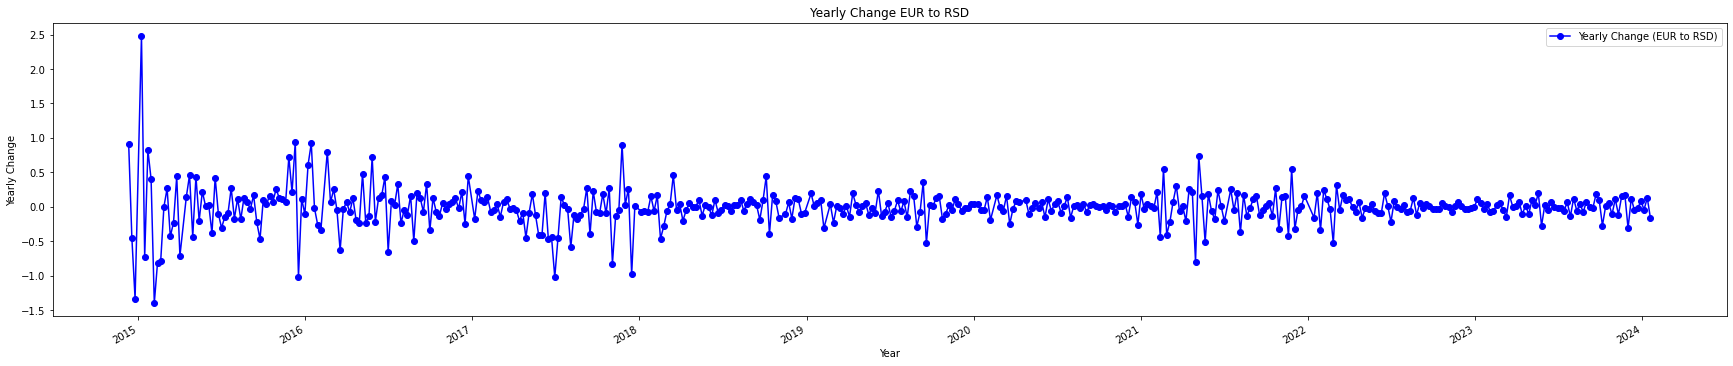

In [0]:
# Velicina grafika
plt.figure(figsize=(30, 6))

# Dodavanje kolone sa godinom
df_eur_to_rsd = df_eur_to_rsd.withColumn("Year", year("Date"))

# Dodavanje kolone sa prethodnom vrednošću kursa (Lag funkcija)
windowSpec = Window().partitionBy("Name").orderBy("Date")
df_eur_to_rsd = df_eur_to_rsd.withColumn("Previous_Close", lag("Close").over(windowSpec))

# Izračunavanje godišnjih promena kursa
df_eur_to_rsd = df_eur_to_rsd.withColumn("Yearly_Change", col("Close") - col("Previous_Close"))

# Prikazivanje rezultata
df_eur_to_rsd.select("Date", "Close", "Previous_Close", "Yearly_Change").show()

# Konverzija rezultata u Pandas DataFrame radi lakšeg crtanja grafikona
df_pandas = df_eur_to_rsd.toPandas()

# Grafikon promena kursa u odnosu na prethodnu godinu
plt.plot_date(date2num(df_pandas["Date"]), df_pandas["Yearly_Change"], '-o', label='Yearly Change (EUR to RSD)', color='blue')
plt.xlabel('Year')
plt.ylabel('Yearly Change')
plt.title('Yearly Change EUR to RSD')
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()


In [0]:
#Analiza promene evropskih valuta u odnosu na evro na 3 meseca u procentima

#U prikazanom grafiku mozemo videti ponasanje sledecih valuta: madjarske forinte (HUF), britanske funte (GBP), svajcarskog franka (CHF) i svedske krune(SEK). Kako je u skupu podataka vremenski period pracenja za neke valute duzi od vremenskog perioda pracenja za druge, najpre je odradjena filtracija da se uvaze samo podaci iz 2014. godine. Vremenski period od prethodnih 10 godina smo podelili na kvartale radi manje gustine podataka. Za svaki dat trenutak pratimo trenutnu protivvrednost valute u odnosu na evro i vrednost u prethodnom kvartalu pa tako mozemo izracunati procentualni rast, odnosno pad te valute za posmatrani kvartal.


+----+-------+----------+----------------------------+
|Year|Quarter|      Name|avg(Daily_Change_Percentage)|
+----+-------+----------+----------------------------+
|2014|      1|EUR to CHF|         -0.0660908297136656|
|2014|      2|EUR to CHF|        -0.02250163462598...|
|2014|      3|EUR to CHF|         -0.0582391750265434|
|2014|      4|EUR to CHF|        -0.02536633745194...|
|2015|      1|EUR to CHF|         -0.9156873637279863|
|2015|      2|EUR to CHF|        -0.04168397427874...|
|2015|      3|EUR to CHF|          0.3948879499351815|
|2015|      4|EUR to CHF|        -0.09192686402624094|
|2016|      1|EUR to CHF|        0.054312901391528556|
|2016|      2|EUR to CHF|        -0.06508523303282143|
|2016|      3|EUR to CHF|          0.0708739875646073|
|2016|      4|EUR to CHF|        -0.15004121961557157|
|2017|      1|EUR to CHF|        -0.00611977573794...|
|2017|      2|EUR to CHF|         0.18799400918474374|
|2017|      3|EUR to CHF|          0.3357860350339139|
|2017|    

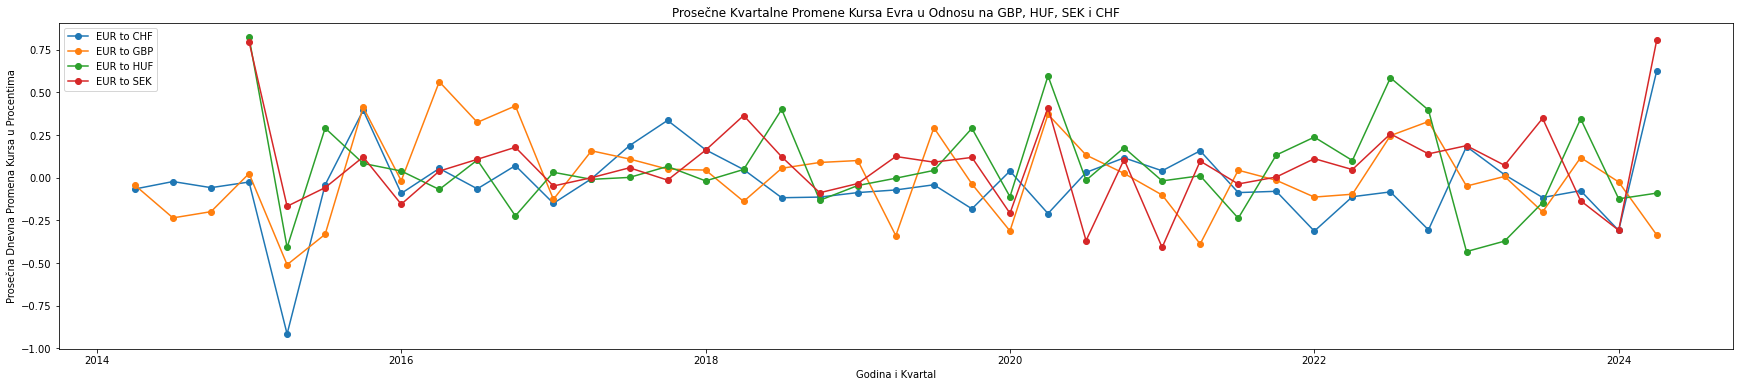

In [0]:
plt.figure(figsize=(30, 6))

# Filtriranje podataka za evro u GBP, HUF, SEK i CHF
df_filtered = df.filter(
    (col('Name').isin(["EUR to GBP", "EUR to HUF", "EUR to SEK", "EUR to CHF"])) &
    (year(col('Date')) >= 2014)
)


# Dodavanje kolone sa prethodnom vrednošću kursa (Lag funkcija)
windowSpec = Window().partitionBy("Name").orderBy("Date")
df_with_lag = df_filtered.withColumn("Previous_Close", lag("Close").over(windowSpec))

# Izračunavanje kvartalnih promena kursa u procentima
df_changes = df_with_lag.withColumn("Quarter", quarter("Date"))
df_changes = df_changes.withColumn("Year", year("Date"))
df_changes = df_changes.withColumn("Daily_Change_Percentage",
                                   when(col("Previous_Close").isNotNull(),
                                        ((col("Close") - col("Previous_Close")) / col("Previous_Close")) * 100)
                                   .otherwise(0))

# Agregacija podataka po kvartalima
df_aggregated = df_changes.groupBy("Name", "Year", "Quarter").agg({"Daily_Change_Percentage": "avg"})

# Prikazivanje rezultata
df_aggregated.select("Year", "Quarter", "Name", "avg(Daily_Change_Percentage)").show()

# Konverzija rezultata u Pandas DataFrame radi lakšeg crtanja grafikona
df_pandas = df_aggregated.toPandas()

# Prikazivanje promena kursa za svaku valutu
for currency_name, currency_df in df_pandas.groupby("Name"):
    quarters = currency_df["Quarter"]
    years = currency_df["Year"]
    changes_percentage = currency_df["avg(Daily_Change_Percentage)"]
    plt.plot(years + quarters / 4, changes_percentage, '-o', label=currency_name)

plt.xlabel('Godina i Kvartal')
plt.ylabel('Prosečna Dnevna Promena Kursa u Procentima')
plt.title('Prosečne Kvartalne Promene Kursa Evra u Odnosu na GBP, HUF, SEK i CHF')
plt.legend()
plt.show()


In [0]:
#Posmatranjem grafika mozemo zakljuciti da je u proteklih 10 godina oscilacije bile ceste, ponekad i velikih razmera. Kao najnestabilniju valutu mozemo definitvno posmatrati madjarsku forintu koja je imala kako nagle skokove (2020, 2018, 2022,...) tako i nagle padove (2015, 2023). Ako izuzmemo pad 2015, koji je pritom najistaknutiji na grafiku, najstabilnijom mozemo proglasiti svajcarski franak i ako je zabelezio skok u trenutno bliskom periodu.
#Zanimljiv podatak je da su retke situacije kada neke valute odskacu u stabilnosti od ostalih, tj kada je za jednu oscilacija mala znaci da je i za ostale, a kada jedna osciluje osciluju sve iz cega mozemo zakljuciti da evro ima neverovatno znacajan uticaj na ove valute pa samim tim i na celokupnu evropsku ekonomiju, cak i van evrozone.